In [107]:
# ============================
# Import Libraries
# ============================
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, classification_report
from xgboost import XGBClassifier, plot_importance
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

In [108]:
def get_dataset():
    # ============================
    # Load Dataset
    # ============================
    df = pd.read_csv("data.csv")

    # ============================
    # Add "_missing" Indicator Columns and Impute
    # ============================
    for col in df.columns:
        if df[col].isnull().sum() > 0:
            df[col + '_missing'] = df[col].isnull().astype(int)
            if df[col].dtype in ['float64', 'int64']:
                df[col] = df[col].fillna(df[col].mean())
            else:
                df[col] = df[col].fillna(df[col].mode()[0])

    df = df.drop(columns=['CLNO_missing',
                 'REASON_missing',
                 'MORTDUE_missing',
                 'DEBTINC_missing',
                ])

    # Drop rows with any remaining NaNs
    df = df.dropna()

    return df

In [109]:
def plot_feature_importances(model):
    # Create a DataFrame for feature importances
    feature_importances = pd.DataFrame({
        'Feature': model.feature_names_in_,
        'Importance': model.feature_importances_
    })

    # Sort by importance
    feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

    # Plot
    plt.figure(figsize=(10, 8))
    plt.barh(feature_importances['Feature'][:20][::-1], feature_importances['Importance'][:20][::-1])
    plt.xlabel('Importance')
    plt.title('Top 20 Feature Importances')
    plt.tight_layout()
    plt.show()

    print(feature_importances)

In [110]:
def train_eval_model(df, classifier_type):
    # ============================
    # One-hot Encode Categoricals
    # ============================
    df = pd.get_dummies(df, drop_first=True)

    # ============================
    # Split Data
    # ============================
    X = df.drop(columns=['BAD'])
    y = df['BAD'].values

    # ============================
    # Stratified K-Fold CV
    # ============================
    k = 5
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

    # Store predictions and labels
    all_probs = []
    all_true = []

    for train_idx, test_idx in skf.split(X, y):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        if classifier_type == "xgb":
            model = XGBClassifier(eval_metric='logloss', random_state=7)
        else:
            model = RandomForestClassifier(random_state=7)
        model.fit(X_train, y_train)

        y_prob = model.predict_proba(X_test)[:, 1]

        all_probs.extend(y_prob)
        all_true.extend(y_test)

    all_probs = np.array(all_probs)
    all_true = np.array(all_true)

    # ============================
    # Threshold Search
    # ============================
    thresholds = np.arange(0.001, 1.00, 0.0001)
    results = []

    for t in thresholds:
        y_pred = (all_probs >= t).astype(int)
        tn, fp, fn, tp = confusion_matrix(all_true, y_pred).ravel()
        recall_bad = tp / (tp + fn)  # BAD = 1
        recall_good = tn / (tn + fp)  # GOOD = 0
        results.append((t, recall_bad, recall_good))

    threshold_df = pd.DataFrame(results, columns=["threshold", "recall_bad", "recall_good"])

    # 🎯 Objective 1: Recall (BAD=1) ≥ 85%, maximize recall_good
    obj1_df = threshold_df[threshold_df["recall_bad"] >= 0.85]
    best_obj1 = obj1_df.sort_values(by="recall_good", ascending=False).head(1)
    best_threshold_1 = best_obj1.iloc[0]['threshold']

    # 🎯 Objective 2: Recall (GOOD=0) ≥ 70%, maximize recall_bad
    obj2_df = threshold_df[threshold_df["recall_good"] >= 0.70]
    best_obj2 = obj2_df.sort_values(by="recall_bad", ascending=False).head(1)
    best_threshold_2 = best_obj2.iloc[0]['threshold']

    # ============================
    # Evaluation Using Best Thresholds
    # ============================
    print("✅ Best Threshold for Objective 1:")
    print(best_obj1)

    y_pred_obj1 = (all_probs >= best_threshold_1).astype(int)
    print("\nConfusion Matrix (Objective 1):")
    print(confusion_matrix(all_true, y_pred_obj1))
    print("\nClassification Report (Objective 1):")
    print(classification_report(all_true, y_pred_obj1, digits=3))

    print("----------------------------------------------------")

    print("✅ Best Threshold for Objective 2:")
    print(best_obj2)

    y_pred_obj2 = (all_probs >= best_threshold_2).astype(int)
    print("\nConfusion Matrix (Objective 2):")
    print(confusion_matrix(all_true, y_pred_obj2))
    print("\nClassification Report (Objective 2):")
    print(classification_report(all_true, y_pred_obj2, digits=3))

    # ============================
    #  ROC Curve with Marked Thresholds
    # ============================

    # Get false positive rate, true positive rate, and thresholds
    fpr, tpr, roc_thresholds = roc_curve(all_true, all_probs)
    roc_auc = auc(fpr, tpr)

    # Plot ROC Curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')

    # Add markers for selected thresholds
    # For each threshold, find the closest point on the ROC curve
    for label, t_value, color in [
        ("Objective 1", best_threshold_1, "red"),
        ("Objective 2", best_threshold_2, "green")
    ]:
        # Find index in roc_thresholds that is closest to the chosen threshold
        idx = np.argmin(np.abs(roc_thresholds - t_value))
        plt.plot(fpr[idx], tpr[idx], marker='o', color=color, label=f'{label} (Threshold={t_value:.4f})')

    plt.xlabel('False Positive Rate (1 - Recall for BAD=0)')
    plt.ylabel('True Positive Rate (Recall for BAD=1)')
    plt.title('ROC Curve with Threshold Markers')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    plot_feature_importances(model)

    return model, best_threshold_1, best_threshold_2, all_probs, all_true

# XGBoost

✅ Best Threshold for Objective 1:
      threshold  recall_bad  recall_good
2410      0.242    0.850294     0.950534

Confusion Matrix (Objective 1):
[[4535  236]
 [ 178 1011]]

Classification Report (Objective 1):
              precision    recall  f1-score   support

           0      0.962     0.951     0.956      4771
           1      0.811     0.850     0.830      1189

    accuracy                          0.931      5960
   macro avg      0.886     0.900     0.893      5960
weighted avg      0.932     0.931     0.931      5960

----------------------------------------------------
✅ Best Threshold for Objective 2:
     threshold  recall_bad  recall_good
136     0.0146    0.985702      0.70174

Confusion Matrix (Objective 2):
[[3348 1423]
 [  17 1172]]

Classification Report (Objective 2):
              precision    recall  f1-score   support

           0      0.995     0.702     0.823      4771
           1      0.452     0.986     0.619      1189

    accuracy                  

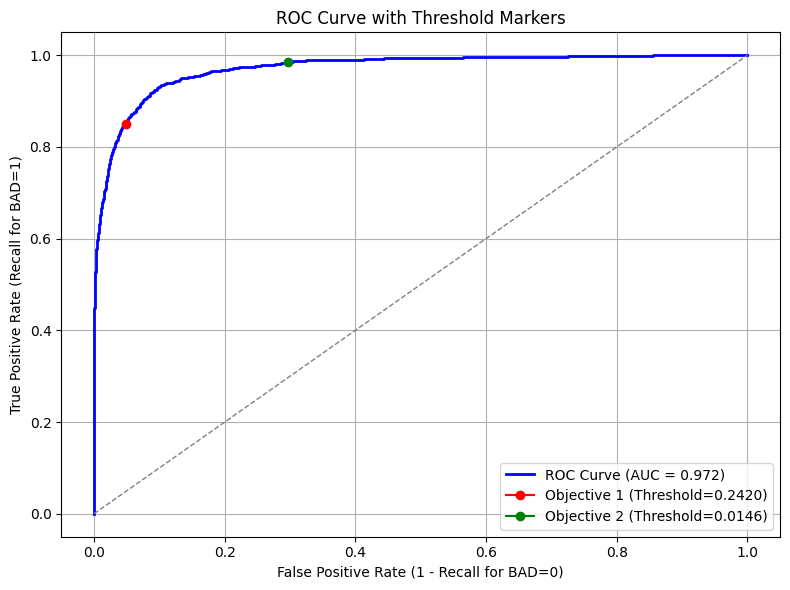

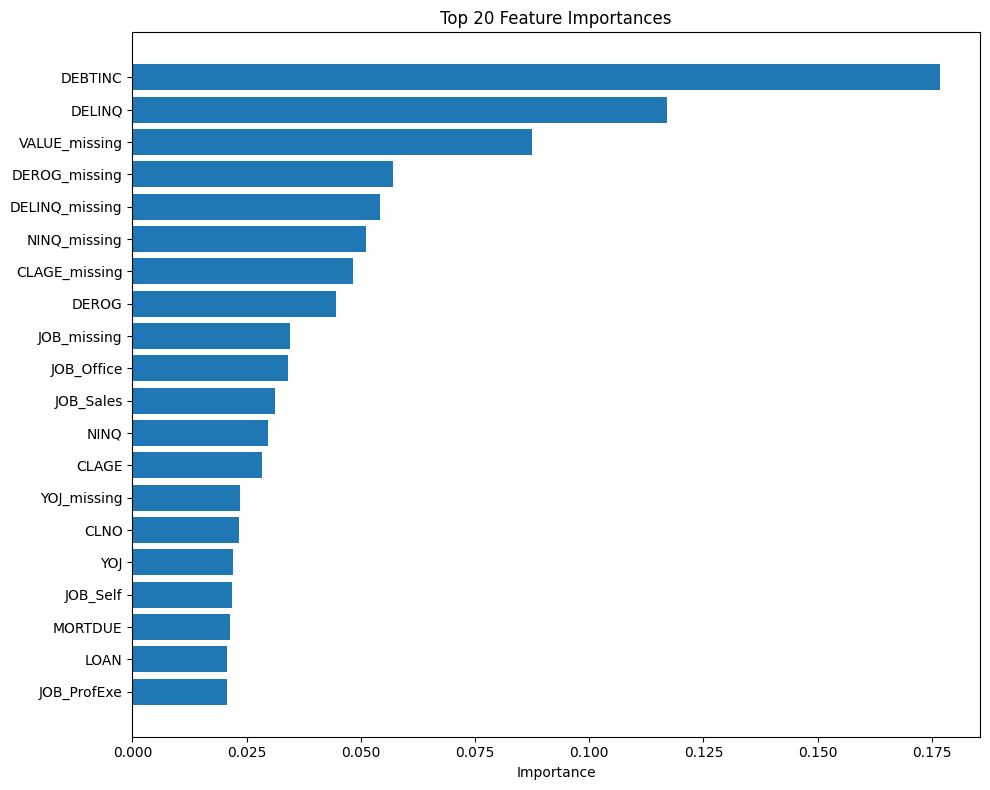

           Feature  Importance
9          DEBTINC    0.176711
5           DELINQ    0.117095
10   VALUE_missing    0.087450
13   DEROG_missing    0.057098
14  DELINQ_missing    0.054252
16    NINQ_missing    0.051241
15   CLAGE_missing    0.048206
4            DEROG    0.044581
11     JOB_missing    0.034555
18      JOB_Office    0.034099
21       JOB_Sales    0.031308
7             NINQ    0.029639
6            CLAGE    0.028283
12     YOJ_missing    0.023553
8             CLNO    0.023374
3              YOJ    0.022043
22        JOB_Self    0.021713
1          MORTDUE    0.021458
0             LOAN    0.020762
20     JOB_ProfExe    0.020653
2            VALUE    0.019873
19       JOB_Other    0.017453
17  REASON_HomeImp    0.014600


In [111]:
df = get_dataset()

xgb_model, xgb_thresh_1, xgb_thresh_2, xgb_probs, y_true_xgb = train_eval_model(df, "xgb")

# Random Forest

✅ Best Threshold for Objective 1:
      threshold  recall_bad  recall_good
3565     0.3575    0.850294     0.958709

Confusion Matrix (Objective 1):
[[4574  197]
 [ 178 1011]]

Classification Report (Objective 1):
              precision    recall  f1-score   support

           0      0.963     0.959     0.961      4771
           1      0.837     0.850     0.844      1189

    accuracy                          0.937      5960
   macro avg      0.900     0.905     0.902      5960
weighted avg      0.937     0.937     0.937      5960

----------------------------------------------------
✅ Best Threshold for Objective 2:
     threshold  recall_bad  recall_good
617     0.0627    0.993272     0.705722

Confusion Matrix (Objective 2):
[[3367 1404]
 [   8 1181]]

Classification Report (Objective 2):
              precision    recall  f1-score   support

           0      0.998     0.706     0.827      4771
           1      0.457     0.993     0.626      1189

    accuracy                  

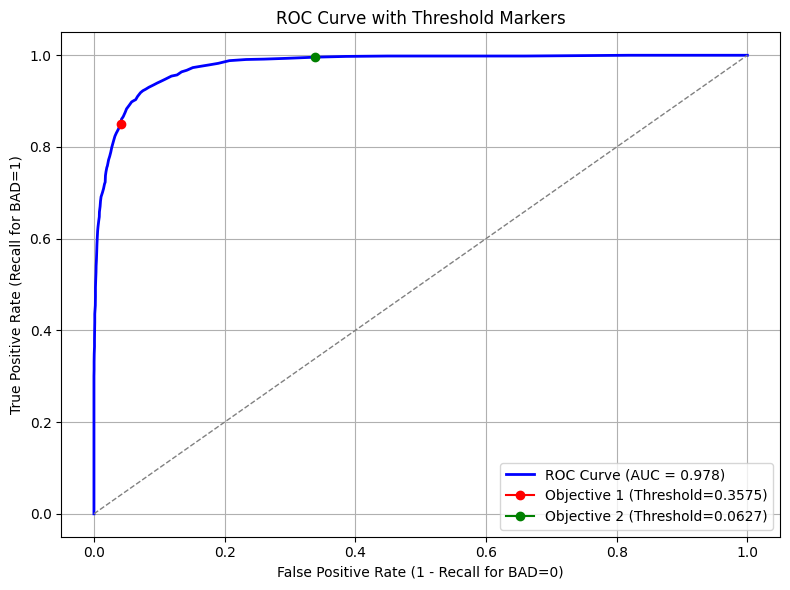

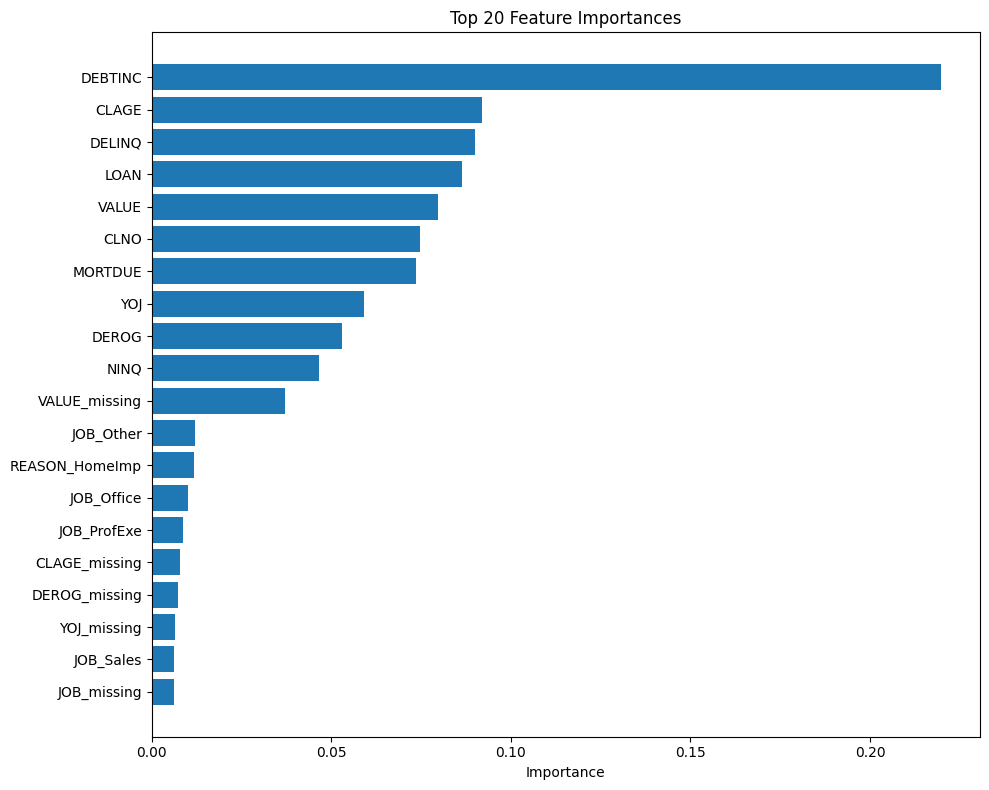

           Feature  Importance
9          DEBTINC    0.219668
6            CLAGE    0.091970
5           DELINQ    0.089877
0             LOAN    0.086274
2            VALUE    0.079564
8             CLNO    0.074684
1          MORTDUE    0.073664
3              YOJ    0.059032
4            DEROG    0.052932
7             NINQ    0.046528
10   VALUE_missing    0.037112
19       JOB_Other    0.011933
17  REASON_HomeImp    0.011752
18      JOB_Office    0.010188
20     JOB_ProfExe    0.008762
15   CLAGE_missing    0.007792
13   DEROG_missing    0.007388
12     YOJ_missing    0.006509
21       JOB_Sales    0.006166
11     JOB_missing    0.006139
22        JOB_Self    0.004284
16    NINQ_missing    0.004273
14  DELINQ_missing    0.003509


In [112]:
df = get_dataset()

rf_model, rf_thresh_1, rf_thresh_2, rf_probs, y_true_rf = train_eval_model(df, "rf")

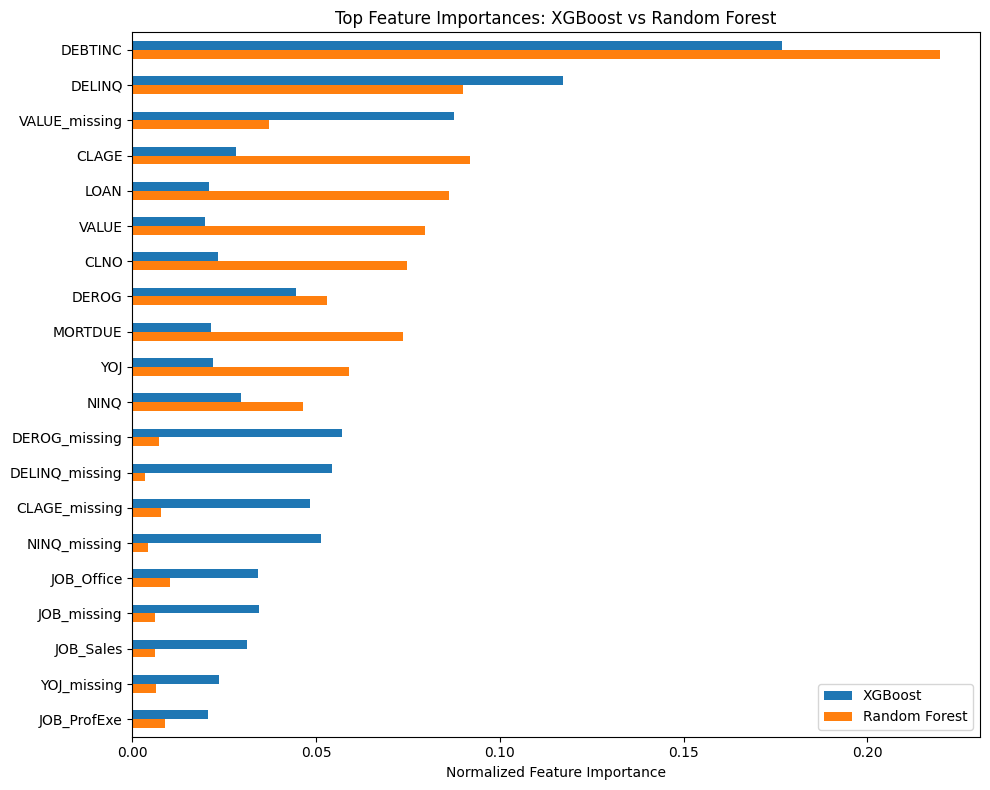

In [113]:
# Get feature importances
xgb_importance = pd.Series(xgb_model.feature_importances_, index=xgb_model.feature_names_in_, name='XGBoost')
rf_importance = pd.Series(rf_model.feature_importances_, index=rf_model.feature_names_in_, name='Random Forest')

# Combine into a single DataFrame
importance_df = pd.concat([xgb_importance, rf_importance], axis=1)

# Normalize importances (optional but makes them comparable)
importance_df = importance_df / importance_df.sum()

# Sort by average importance
importance_df['mean'] = importance_df.mean(axis=1)
importance_df = importance_df.sort_values(by='mean', ascending=False).drop(columns='mean')

# Plot top N features
top_n = 20
importance_df.head(top_n).plot(kind='barh', figsize=(10, 8))
plt.xlabel("Normalized Feature Importance")
plt.title("Top Feature Importances: XGBoost vs Random Forest")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

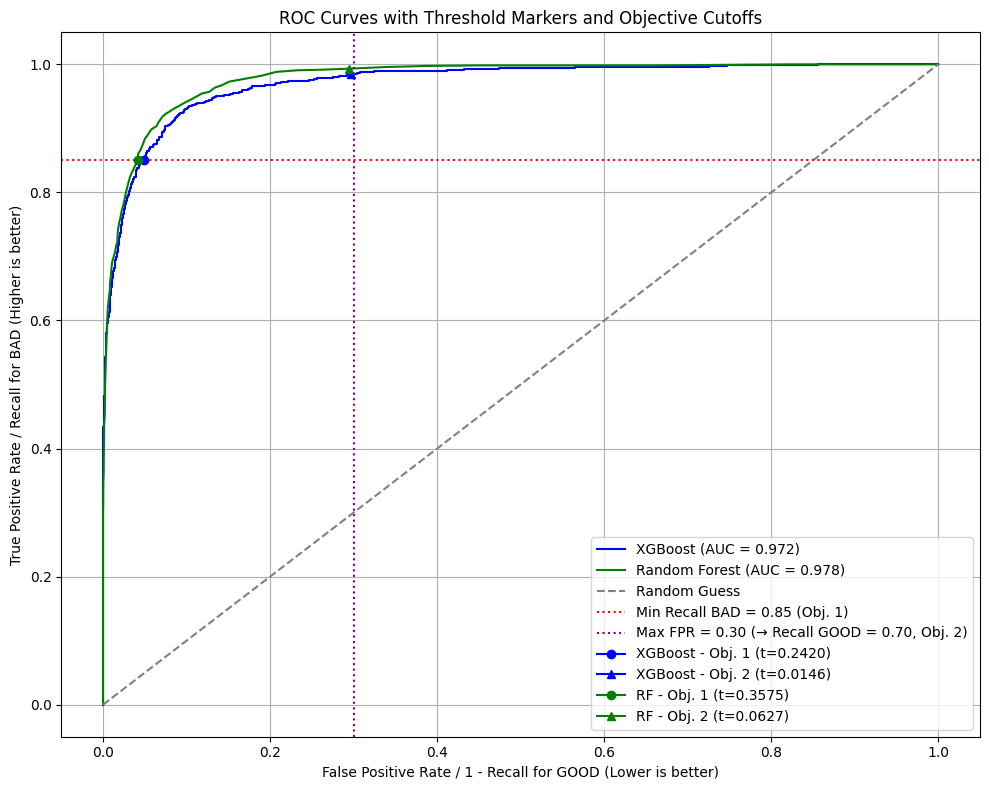

In [116]:
# Check that the target arrays are the same
assert np.array_equal(y_true_xgb, y_true_rf), "Target labels differ between models"

fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(y_true_xgb, xgb_probs)
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_true_rf, rf_probs)
auc_xgb = auc(fpr_xgb, tpr_xgb)
auc_rf = auc(fpr_rf, tpr_rf)

# Plot both ROC curves
plt.figure(figsize=(10, 8))
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {auc_xgb:.3f})', color='blue')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {auc_rf:.3f})', color='green')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guess')

# Plot objective threshold lines
plt.axhline(y=0.85, color='red', linestyle=':', linewidth=1.5, label='Min Recall BAD = 0.85 (Obj. 1)')
plt.axvline(x=0.30, color='purple', linestyle=':', linewidth=1.5, label='Max FPR = 0.30 (→ Recall GOOD = 0.70, Obj. 2)')

# Threshold markers
def mark_threshold(thresholds, fpr, tpr, t_value, label, color, marker):
    idx = np.argmin(np.abs(thresholds - t_value))
    plt.plot(fpr[idx], tpr[idx], marker=marker, color=color,
             label=f'{label} (t={t_value:.4f})')

# Threshold markers
mark_threshold(thresholds_xgb, fpr_xgb, tpr_xgb, xgb_thresh_1, "XGBoost - Obj. 1", "blue", 'o')
mark_threshold(thresholds_xgb, fpr_xgb, tpr_xgb, xgb_thresh_2, "XGBoost - Obj. 2", "blue", '^')
mark_threshold(thresholds_rf, fpr_rf, tpr_rf, rf_thresh_1, "RF - Obj. 1", "green", 'o')

# Get actual confusion matrix at threshold
rf_y_pred_obj2 = (rf_probs >= rf_thresh_2).astype(int)
tn, fp, fn, tp = confusion_matrix(y_true_rf, rf_y_pred_obj2).ravel()
fpr_actual = fp / (fp + tn)
tpr_actual = tp / (tp + fn)

# Plot marker using actual FPR/TPR
plt.plot(fpr_actual, tpr_actual, marker='^', color='green', label=f'RF - Obj. 2 (t={rf_thresh_2:.4f})')
# mark_threshold(thresholds_rf, fpr_rf, tpr_rf, rf_thresh_2, "RF - Obj. 2", "green", '^')


# Labels and layout
plt.xlabel('False Positive Rate / 1 - Recall for GOOD (Lower is better)')
plt.ylabel('True Positive Rate / Recall for BAD (Higher is better)')
plt.title('ROC Curves with Threshold Markers and Objective Cutoffs')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()